<a href="https://www.kaggle.com/code/giuliobenedetti/imagenet-reproducing-convnets?scriptVersionId=155860678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In this notebook, we aim to reproduce the model from [_Zimonyan & Zisserman 2015_](https://arxiv.org/pdf/1409.1556v6.pdf). In other words, we will design an analogous model on TensorFlow, train it with the data from the [ImageNet Object Classification Challenge](https://www.kaggle.com/competitions/imagenet-object-localization-challenge) and ultimately benchmark its performance with the original model.

In [2]:
# Import packages

# Data analysis
import numpy as np
import pandas as pd

# File management
import os
import shutil

# Image visualisation
import matplotlib.pyplot as plt

# Neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [4]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-12-20 20:23:07.363187: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:23:07.363322: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:23:07.363434: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:23:07.363511: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:23:07.363612: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:23:07.363814: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:23:07.363904: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

Here we list the constants that will be used for preprocessing and model design.

In [5]:
# Define constants

# Set batch size for mini-batch gradient descent
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
# Set number of epochs to train model
EPOCH_NUM = 74

# Set kernel size for Conv2D layers
KERNEL_SIZE = 3
# Set padding mode for Conv2D layers
PAD_MODE = "same"
# Set activation function for Conv2D layers
ACTIVATION = "relu"

# Set pool size for MaxPool2D layers
POOL_SIZE = 2
# Set strides for MaxPool2D layers
POOL_STRIDES = 2

# Data Preprocessing

Because the train set is big (`train_dir`), we take a subset of classes defined by `CLASS_NUM` and process the images belonging to that subset of classes by rescaling and cropping them. Initially, we will train the model using only this subset.

In [7]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge/"
train_dir = base_dir + "ILSVRC/Data/CLS-LOC/train/"
devel_dir = base_dir + "ILSVRC/Data/CLS-LOC/val/"

dataset = tf.data.Dataset.list_files(train_dir + "*/*.JPEG", shuffle=False)
image_count = tf.data.experimental.cardinality(dataset).numpy()

dataset = dataset.shuffle(image_count, reshuffle_each_iteration=False)

In [8]:
class_names = np.array(sorted(os.listdir(train_dir)))

# Set number of classes to use (this is a way to subset the data)
CLASS_NUM = len(class_names)

for f in dataset.take(5):
    print(f.numpy())

b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n02102973/n02102973_3695.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01820546/n01820546_6764.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n03187595/n03187595_5121.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n02096177/n02096177_13066.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n02087394/n02087394_6371.JPEG'


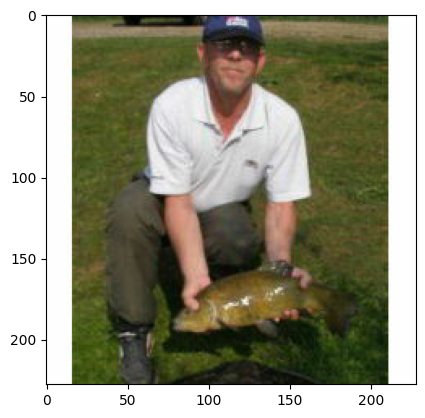

In [10]:
def process_path(file_path):
# Convert the compressed string to a 3D uint8 tensor
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 228, 228)

    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    label = parts[-2] == class_names
    
    return img, label

img, label = process_path(train_dir + "n01440764/n01440764_10026.JPEG")
input_shape = img.shape

plt.imshow(img)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
dataset = dataset.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    #print("Label: ", label.numpy())

Image shape:  (228, 228, 3)


In [13]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

dataset = configure_for_performance(dataset)

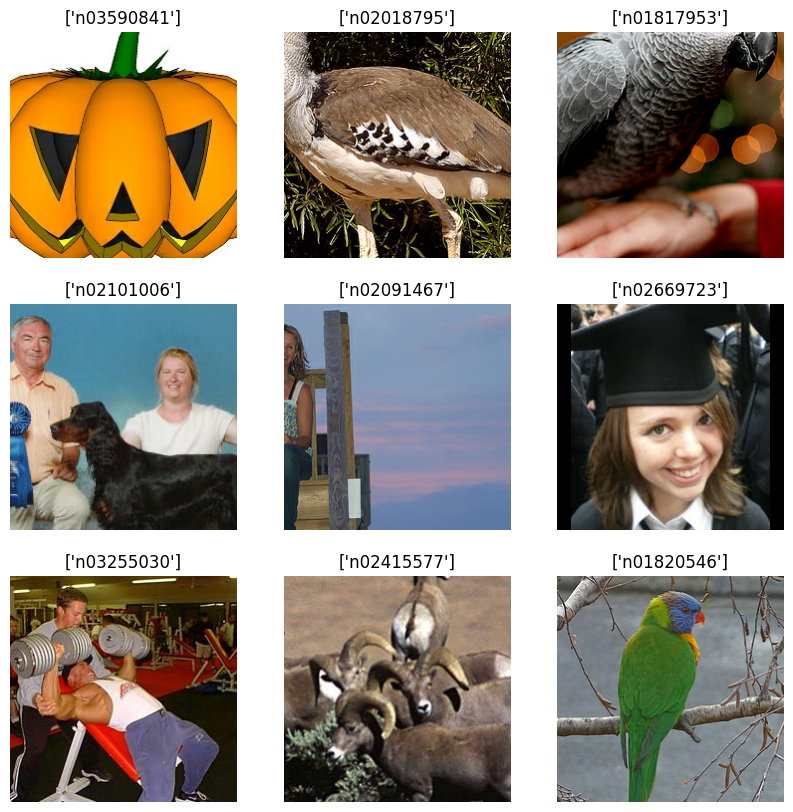

In [14]:
image_batch, label_batch = next(iter(dataset))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

# Model Design

In general, the model architecture resembles the model from the paper pretty well, even though some details may still be missing.

In [15]:
# Design model
def create_model():
    
    model = keras.models.Sequential([

        # 1st convolutional block
        layers.Conv2D(input_shape=input_shape, filters=64, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 2nd convolutional block
        layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 3rd convolutional block
        layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 4th convolutional block
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 5th convolutional block
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # Classifier head
        layers.Flatten(),
        layers.Dense(4096, activation=ACTIVATION),
        layers.Dropout(rate=0.5),
        layers.Dense(4096, activation=ACTIVATION),
        layers.Dropout(rate=0.5),
        layers.Dense(CLASS_NUM, activation="softmax")
    ])
    
    return model

In [17]:
with tpu_strategy.scope():
    
    model = create_model()
    
    # Define optimiser
    sgd_optimiser = keras.optimizers.experimental.SGD(
        learning_rate=0.01,
        momentum=0.90,
        nesterov=False,
        weight_decay=0.0005
    )
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

To test that the model works, we train it for a few epochs. Ideally, we will train the model on the full dataset when once it resembles the model from the paper in terms of parameter number. 

In [ ]:
# Update learning rate
LR_Decay = keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

steps_per_epoch = 60000 // BATCH_SIZE

# Train the model
history = model.fit(
    dataset,
    epochs=EPOCH_NUM,
    steps_per_epoch=steps_per_epoch,
    batch_size=BATCH_SIZE,
    verbose=True,
    callbacks=[LR_Decay]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/74


2023-12-20 20:26:56.793039: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:26:56.810871: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:26:56.827758: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:26:56.846095: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:26:56.864002: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:26:56.881522: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:26:56.898768: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  2/468 [..............................] - ETA: 46s - loss: 8.9515 - categorical_accuracy: 0.0000e+00     

2023-12-20 20:27:18.006566: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:27:18.006703: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:27:18.006797: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:27:18.006955: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:27:18.007038: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:27:18.007152: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:27:18.007230: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 63/468 [===>..........................] - ETA: 33s - loss: 6.9837 - categorical_accuracy: 8.6806e-04

2023-12-20 20:27:23.028294: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-20 20:27:23.028605: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


188/468 [===========>..................] - ETA: 22s - loss: 6.9331 - categorical_accuracy: 8.3112e-04

2023-12-20 20:27:33.050494: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


314/468 [===================>..........] - ETA: 12s - loss: 6.9227 - categorical_accuracy: 9.7034e-04

2023-12-20 20:27:43.088441: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


327/468 [===================>..........] - ETA: 11s - loss: 6.9219 - categorical_accuracy: 9.5566e-04

2023-12-20 20:27:44.120095: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


468/468 [==============================] - 59s 80ms/step - loss: 6.9162 - categorical_accuracy: 0.0010 - lr: 0.0100
Epoch 2/74
287/468 [=================>............] - ETA: 14s - loss: 6.8892 - categorical_accuracy: 0.0011

2023-12-20 20:28:18.161143: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


413/468 [=========================>....] - ETA: 4s - loss: 6.8833 - categorical_accuracy: 0.0014

2023-12-20 20:28:28.202848: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


445/468 [===========================>..] - ETA: 1s - loss: 6.8813 - categorical_accuracy: 0.0014

2023-12-20 20:28:30.762679: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


468/468 [==============================] - 37s 80ms/step - loss: 6.8796 - categorical_accuracy: 0.0014 - lr: 0.0100
Epoch 3/74
468/468 [==============================] - 37s 79ms/step - loss: 6.8399 - categorical_accuracy: 0.0021 - lr: 0.0100
Epoch 4/74
468/468 [==============================] - 38s 80ms/step - loss: 6.8046 - categorical_accuracy: 0.0024 - lr: 0.0100
Epoch 5/74
468/468 [==============================] - 38s 81ms/step - loss: 6.7623 - categorical_accuracy: 0.0032 - lr: 0.0100
Epoch 6/74
468/468 [==============================] - 39s 82ms/step - loss: 6.6625 - categorical_accuracy: 0.0036 - lr: 0.0100
Epoch 7/74
103/468 [=====>........................] - ETA: 29s - loss: 6.6023 - categorical_accuracy: 0.0037

The model contains 128778627 trainable parameters, which aligns pretty well with the 33 million in the paper. Our model may still lack some element responsible for the missing 4 million parameters.

In [ ]:
# Visualise loss
history_df.loc[:, "loss"].plot(title="Loss")

In [ ]:
# Visualise accuracy
history_df.loc[:, "categorical_accuracy"].plot(title="Accuracy")

# Transfer Learning

The next step involves building a deeper ConvNet by:
1. taking the pretrained base from the previous section,
2. enriching it with new untrained convolutional layers and
3. attaching it to a new untrained classification head

By transferring the learnt weight from our previous model, we can build more complex and deeper ConvNets without too much computational burden. In particular, here we aim to reproduce the following four architectures from _Zimonyan & Zisserman 2015_:
- 13-layer ConvNet
- 16-layer ConvNet (with 1-by-1 filters)
- 16-layer ConvNet (with 3-by-3 filters)
- 19-layer ConvNet

In the following cell, we pretend that the previously trained model is stored in a keras file to show how pretrained models can be imported into a notebook.

In [ ]:
'''# Define model file
model_file = f"/kaggle/working/{CLASS_NUM}class_model.keras"

# Save model into file for replication purposes
model.save(model_file)

# Import pretrained base
new_model = keras.models.load_model(model_file)

# IMPORTANT: Set weights from base as untrainable
new_model.trainable = False'''

Because we want to add new convolutional layers between the pretrained ones, we have to separate the latter from the whole pretrained base as done below.

In [ ]:
'''# List indices of relevant layers (only convolutional, no maxpool)
layer_positions = [0, 2, 4, 5, 7, 8, 10, 11]

# Select relevant layers
pretrained_layers = [new_model.get_layer(index=i) for i in layer_positions]'''

## 13-layer ConvNet

Here, we build and train a 13-layer ConvNet with a half pretrained half untrained base.

In [ ]:
'''# Design model
model = keras.models.Sequential([
    
    # 1st convolutional block
    pretrained_layers[0],
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 2nd convolutional block
    pretrained_layers[1],
    layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 3rd convolutional block
    pretrained_layers[2],
    pretrained_layers[3],
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 4th convolutional block
    pretrained_layers[4],
    pretrained_layers[5],
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 5th convolutional block
    pretrained_layers[6],
    pretrained_layers[7],
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # Classifier head
    layers.Flatten(),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(CLASS_NUM, activation="softmax")
])

# Choose optimiser, loss function and validation metric
model.compile(
    optimizer=keras.optimizers.experimental.SGD(momentum=0.9, weight_decay=0.0005),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)'''

In [ ]:
'''# Train the model
history = model.fit(
    dataset,
    epochs=2,
    batch_size=BATCH_SIZE,
    verbose=True
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")'''

In [ ]:
# Visualise loss
#history_df.loc[:, "loss"].plot(title="Loss")

In [ ]:
# Visualise accuracy
#history_df.loc[:, "categorical_accuracy"].plot(title="Accuracy")